In [94]:
import warnings
warnings.filterwarnings("ignore")

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import edward2 as ed
import numpy as np
import scipy as sp
import scipy.stats
tfd = tfp.distributions

/home/simon/miniconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/simon/miniconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/simon/miniconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
import matplotlib.pyplot as plt

In [269]:
n = 100

In [274]:
normal_data = sp.stats.norm.rvs(5, 1, size=n)

In [275]:
def scale_fn():
    r = sp.stats.normal.rvs(5)
    print("yielding {}".format(r))
    return r

In [276]:
def log_likelihood(scale):    
    mu = ed.Normal(0, 1, sample_shape=1, name="mu")    
    y = ed.Normal(loc=tf.ones(n) * mu, scale=scale, name="y")
    return y

In [277]:
def target_log_prob_fn(mu, scale):
    log_joint = ed.make_log_joint_fn(log_likelihood)
    return log_joint(scale, mu=mu, y=normal_data)

In [278]:
niter = 10

states = tf.ones(1)
scales = np.zeros(niter, dtype=np.float32)

hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn = lambda mu: target_log_prob_fn(mu, scales[0]),
    step_size=0.01, num_leapfrog_steps=10)

with tf.Session() as sess:
    for i in range(1, niter):
        states, kernel_states = tfp.mcmc.sample_chain(
                num_results=1, 
                current_state=states,
                #previous_kernel_results=kernel_results,
                kernel = hmc_kernel, num_burnin_steps=0)
        states, kernel_states = sess.run([states, kernel_results])
        states  = states.reshape((1))
        scales[i] = scale_fn()
        print(states)
        hmc_kernel._parameters['target_log_prob_fn'] = \
            lambda mu: target_log_prob_fn(mu, scale_fn())

TypeError: Fetch argument array([0.], dtype=float32) has invalid type <class 'numpy.ndarray'>, must be a string or Tensor. (Can not convert a ndarray into a Tensor or Operation.)

In [241]:
states.shape

(1000, 1)

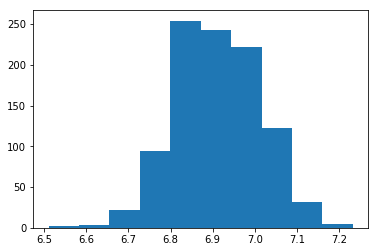

In [242]:
plt.hist(states);

In [263]:
with tf.Session() as sess:    
    states, kernel_results = tfp.mcmc.sample_chain(
        num_results=10,        
        current_state=tf.ones(10),
        kernel = hmc_kernel, num_burnin_steps=1)
    states, is_accepted_ = sess.run([states, kernel_results.is_accepted])        
    print(states)                

ValueError: Incompatible shape for initialization argument 'value'. Expected (1,), got (10,).

In [74]:
with tf.Session() as sess:
    sam = sess.run([normal])

In [114]:
scipy.stats.uniform.rvs(0, 1)

0.27924741993949376

In [279]:
def sample_poisson(last, accept=0.5):
    proposal = scipy.stats.poisson.rvs(last)
    q_p = scipy.stats.poisson.pmf(proposal, last)
    q_last = scipy.stats.poisson.pmf(last, proposal)
    f_p = scipy.stats.poisson.pmf(proposal, 7)
    f_last = scipy.stats.poisson.pmf(last, 7)
    
    a = np.minimum(1., (f_p * q_last) / (f_last * q_p))
    if a > scipy.stats.uniform.rvs(0, 1):
        return proposal
    return last

In [280]:
proposals = np.ones(10000)
for i in range(1, 10000):
    proposals[i] = sample_poisson(proposals[i - 1])

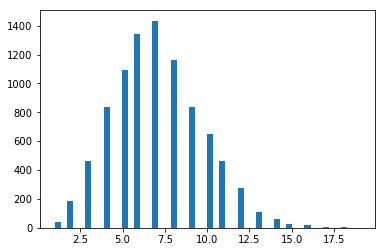

In [281]:
plt.hist(proposals[1000:], bins=50);

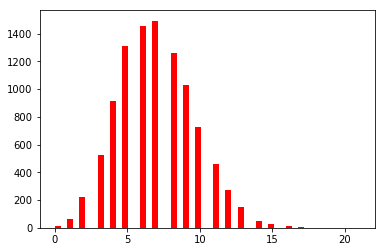

In [282]:
plt.hist(scipy.stats.poisson.rvs(7, size=10000), color="red", bins=50);

In [316]:
n = 10
normal_data = sp.stats.norm.rvs(5, 1, size=n)

In [378]:
def log_likelihood(n, scale):
    m = ed.Normal(tf.zeros(n) + scale, 1, name="m")
    y = ed.Normal(m, scale=1, name="y")
    return y

In [379]:
def target_log_prob_fn(m, scale, n):
    return ed.make_log_joint_fn(log_likelihood)(
        n, scale, m=m, y=normal_data)

In [380]:
kernel = tfp.mcmc.HamiltonianMonteCarlo(
                step_size=0.5, num_leapfrog_steps=2,
                target_log_prob_fn=lambda m: target_log_prob_fn(m, scale, n))

In [387]:
loc = 2
with tf.Session() as sess:    
    
    states, kernel_results = tfp.mcmc.sample_chain(
            current_state=tf.random_uniform(shape=(n,)), num_results=1, 
        kernel=kernel, num_burnin_steps=0)
    states, kernel_results = sess.run([states, kernel_results])  
    print(states)
    for i in range(10):
        states, kernel_results = tfp.mcmc.sample_chain(
            current_state=states,#.reshape((n)),
            num_results=1,
            kernel=kernel, 
            previous_kernel_results=kernel_results,
            num_burnin_steps=0)

        states, kernel_results = sess.run([states, kernel_results])
        states = state.reshape((n))
        kernel._parameters['target_log_prob_fn'] = \
            lambda m: target_log_prob_fn(m, i * 2, n)
        
#         kernel = tfp.mcmc.HamiltonianMonteCarlo(
#                 step_size=0.5, num_leapfrog_steps=2,
#                 target_log_prob_fn=lambda m: target_log_prob_fn(m, i * 2, n))
        print(states)

[[1.168584   3.3418767  2.484744   1.9741161  1.8434137  2.1303825
  0.63862723 0.84430933 2.3953886  2.5208526 ]]


ValueError: Incompatible shape for initialization argument 'value'. Expected (10,), got (1, 10).

In [203]:
current_state = tf.zeros(1)
proposals = np.zeros(shape=(2, 10000))
with tf.Session() as sess:    
    for idx in range(1, 10000):
        proposals[0, i] = sample_poisson(proposals[0, i - 1])
        states, kernel_results = tfp.mcmc.sample_chain(
            current_state=states,            
            num_results=1,
            kernel=kernel, num_burnin_steps=0)
        states, kernel_results = sess.run([states, kernel_results])
        kernel._parameters["target_log_prob_fn"] = 
        states = states.reshape((1))
        if idx % 10 == 0:
            print(states)        
        proposals[1, i] = states

SyntaxError: invalid syntax (<ipython-input-203-38932f371cd0>, line 11)